In [1]:
import numpy as np
import pandas as pd # only used to read the MNIST data set
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import random
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from sklearn.svm import SVC, LinearSVC



In [2]:
import os
os.path.abspath(os.getcwd())

'/Users/zs18656/Documents/GitHub/CDT_Laptop/CDT/Applied Data Science'

In [3]:
def create_weights(shape, low=-1.0, high=1.0, sparsity=None, spectral_radius=None):
    w = (high - low)*np.random.ranf(shape[0]*shape[1]).reshape(shape) + low      # create the weight matrix
    if not sparsity is None:                                                     # if sparsity is defined
        s = np.random.ranf(shape[0]*shape[1]).reshape(shape) < (1.0 - sparsity)  #     create a sparse boolean matrix
        w *= s                                                                   #     set weight matrix values to 0.0
    if not spectral_radius is None:                                              # if spectral radius is defined
        sp = np.max(np.abs(np.linalg.eig(w)[0]))                                 #     compute current spectral radius
        w *= (spectral_radius)/sp                                                #     adjust weight matrix to acheive specified spectral radius
    return w

def operate_reservoir(w_u, w_x, img_1, img_2, ones = True, remove_node_idxs = []):
    n_cols = img_1.shape[1]    # number of image columns = number teaching steps
    x_size = w_x.shape[0]      # reservoir size
    u_size = w_u.shape[1]      # input vector size

    x = np.zeros((x_size,1))    # start with zero reservoir value for each image pair
    for col in (range(n_cols)):   # step through image columns
        img_col_1 = img_1[:,col].reshape((u_size-1,1))
        img_col_2 = img_2[:,col].reshape((u_size-1,1))
        #
        # this technique is somewhat different than what is described in either paper
        #
        if ones == True:
            u_1 = np.dot(w_u, np.vstack((1, img_col_1)))    # Apply wu to each image seperately then add element wise
            u_2 = np.dot(w_u, np.vstack((1, img_col_2)))    # 
            u_total = np.add(u_1, u_2)            # join the transformed inputs to get to 100% reservoir size
        if ones == False:
            u_1 = np.dot(w_u, np.vstack((1, img_col_1)))    # stack up bias (=1) for img_1 column and transform by input weights (1/2 reservoir size)
            u_2 = np.dot(w_u, np.vstack((1, img_col_2)))    # stack up bias (=1) for img_2 column and transform by input weights (1/2 reservoir size)
            u_total = np.concatenate((u_1, u_2))            # join the transformed inputs to get to 100% reservoir size

        u_total[remove_node_idxs] = 0
        #         x = u_total + np.dot(w_x, x)           # update the reservoir without nonlinear activation
        x = np.tanh(u_total + np.dot(w_x, x))           # update the reservoir
        #
        # collect reservoir to reservoir state
        #
        if col == 0:                              # if this is first column
            x_state = (x)                         #     initialize state
        else:                                     # subsequently
            x_state = np.hstack((x_state, (x)))   #     append latest reservoir to state

    return x_state

def display_reservoir_damping(w, n_steps):
    x_size = w.shape[0]
    x = (2.0*np.random.ranf(x_size) - 1.0).reshape(x_size,1)    # initialize reservoir to random values
    for i in range(n_steps):                                    # for a given number of steps
        x = np.tanh((np.dot(w,x)))                              #     operate the reservoie
        if i == 0:                                              #     and collect the interim states
            M = x
        else:
            M = np.hstack((M,x))

    n_plots = min(M.shape[0], 20)                               # format the plot area
    rows = int(np.floor(np.sqrt(n_plots)))
    cols = int(np.ceil(n_plots/rows))
    x_size = M.shape[0]
    if n_plots > 20:                                            # if reservoir size is greater than 20
        cells = np.random.choice(np.arange(x_size), 20)         #    select 20 random neurons for display
    else:
        cells = np.arange(x_size)

    n_steps = M.shape[1]
    x_axis = np.arange(n_steps, dtype=np.int)
    fig, _axs = plt.subplots(nrows=rows, ncols=cols)
    for p in range(n_plots):
        idx = cells[p] 
        row = p//cols
        col = p % cols
        _axs[row][col].plot(x_axis, M[idx, :])
    fig.tight_layout()
    plt.show()
    
def choose_img_pair(digits, img_pair_label):
    digit_1 = np.random.choice(digits)                     #     pick a random base digit
    digit_idx_1 = np.random.choice(len(images[digit_1]))   #     pick a random instance of the base digit
    img_1 = images[digit_1][digit_idx_1, :, :]             #     get the base digit image
    if img_pair_label == 'different':
        # choose a digit different from digit_1
        digit_2 = np.random.choice([digit for digit in ALL_DIGITS if digit != digit_1])
        digit_idx_2 = np.random.choice(len(images[digit_2]))             # pick a random instance of the comparison digit
        img_2 = images[digit_2][digit_idx_2, :, :]                       # get the comparison image
    else:
        digit_idx_2 = np.random.choice(len(images[digit_1]))    # pick a random instance of the base digit
        img_2 = images[digit_1][digit_idx_2, :, :]              # get the comparison digit
        if img_pair_label == 'similar':
            screen_1 = np.random.rand(IMG_ROWS, IMG_COLS)           # create a random screen to choose which pixels to change
            screen_2 = np.random.rand(IMG_ROWS, IMG_COLS)           # create a random screen of values to change the selected pixels to
            img_2[screen_1 > 0.80] = screen_2[screen_1 > 0.80]*0.3  # add random noise at random locations
        elif img_pair_label == 'rot90':
            img_2 = np.fliplr(img_2.T)                              # rotate the image 90 degrees
        elif img_pair_label == 'zoom':
            img_2 = img_2.repeat(2,axis=0).repeat(2,axis=1)[IMG_ROWS//2:IMG_ROWS//2 + IMG_ROWS, IMG_COLS//2:IMG_COLS//2 + IMG_COLS]
        elif img_pair_label == 'blur':                              # blur the image using the convolution kernel
            img_2 = convolve2d(img_2, KERNEL, boundary='wrap', mode='same')
        else:
            raise ValueError('illegal image pair label')
    return img_1, img_2

def eval_Dset(_DIGITS, N_IMG_PAIRS, sample_nodes, remove_node_idxs,
              w_u, w_x, ones = True, model = None):
    y_true = []
    y_pred = []
    for img_pair_label in IMG_PAIR_LABELS:                              # for each comparison type
        img_pair_label_idx = IMG_PAIR_LABELS.index(img_pair_label)
        for img_pair_test in range(N_IMG_PAIRS):                   # for each testing example
            img_1, img_2 = choose_img_pair(_DIGITS, img_pair_label)
            x_state = operate_reservoir(w_u=w_u, w_x=w_x, img_1=img_1, ones = ones, img_2=img_2, remove_node_idxs = remove_node_idxs)  # x_state 1000 x 28, y_state 5 x 28
            x_state = x_state[sample_nodes] #Sampled nodes is the idxs of nodes we take as output
            # predict label
            if model == None:
                y_state = np.tanh(np.dot(w_out, x_state))   # compute the label values for all image columns
                y_mean = y_state.mean(axis=1)               # compute the mean of each value in the label
                y_norm = y_mean/sum(y_mean)                 # normalize by dividing by the sum of the means
                pair_label_pred = np.argmax(y_norm)         # the predicted label is the index of maxium value
            else:
                y_state = model.predict(x_state.T)
                lst = list(y_state)
                pair_label_pred = max(set(lst), key=lst.count)
            y_true.append(img_pair_label_idx)
            y_pred.append(pair_label_pred)

    f_score = accuracy_score(y_true, y_pred)
    return f_score

def getSampleNodes(W_o_N):
    selected_nodes = np.zeros(X_SIZE)
    selected_nodes[:W_o_N] = 1
    sample_nodes = random.sample(list(selected_nodes), k=X_SIZE)
    indices = [i for i, x in enumerate(sample_nodes) if x == 1]
    return indices
def getLCaverage(LC_repeats, LC_length):
    LC = []
    LC_std = []
    for i in range(LC_length):
        ep_i = [x[i] for x in LC_repeats]        
        LC.append(np.mean(ep_i))
        LC_std.append(np.std(ep_i))
    return np.array(LC), np.array(LC_std)

def get_Dset(_DIGITS, N_IMG_PAIRS, sample_nodes, remove_node_idxs, w_u, w_x, ones = True):
    y_true = []
    x_res = []
    for img_pair_label in IMG_PAIR_LABELS:                              # for each comparison type
        img_pair_label_idx = IMG_PAIR_LABELS.index(img_pair_label)
        for img_pair_test in range(N_IMG_PAIRS):                   # for each testing example
            img_1, img_2 = choose_img_pair(_DIGITS, img_pair_label)
            x_state = operate_reservoir(w_u=w_u, w_x=w_x, img_1=img_1, ones = ones, img_2=img_2, remove_node_idxs = remove_node_idxs)  # x_state 1000 x 28, y_state 5 x 28
            x_state = x_state[sample_nodes]
            for res_s in x_state.T:
                x_res.append(res_s)
                y_true.append(img_pair_label_idx)
    
    return np.array(x_res), np.array(y_true)

def AggregateData(best_100, impo_100): # This code is good when we only consider the top 100 stuff
    all_node_idxs, all_node_imp = [], []
    for idx in range(len(best_100)):
        for i in best_100[idx]:
            all_node_idxs.append(i)
        for i in impo_100[idx]:
            all_node_imp.append(i)

    all_node_idxs = np.array(all_node_idxs)
    all_node_imp = np.array(all_node_imp)

    id_imp_list = []
    for node_id in range(2952):
        indices = [i for i, x in enumerate(all_node_idxs) if x == node_id]
        summed_imp = np.mean(all_node_imp[indices])
        if summed_imp > 0:
            id_imp_list.append([node_id, summed_imp])


    ids = [x[0] for x in id_imp_list]
    imps = [x[1] for x in id_imp_list]
    return ids, imps

In [4]:
def run_full_res(model, w_u, w_x):
    if w_u.shape[0] != X_SIZE:
        ones = False
    else:
        ones = True
    for n_outputs in (N_outputs_list):
        sample_nodes = getSampleNodes(n_outputs)
        for img_pair_label in (IMG_PAIR_LABELS):                         # for each comparison type
            img_pair_label_idx = IMG_PAIR_LABELS.index(img_pair_label)
            for img_pair_teach in range(N_TEACH_IMG_PAIRS):            # for the number of teaching examples
                img_1, img_2 = choose_img_pair(TEACH_DIGITS, img_pair_label)
                x_state = operate_reservoir(w_u=w_u, w_x=w_x, ones = ones, img_1=img_1, img_2=img_2, remove_node_idxs=remove_node_idxs)  # x_state 1000 x 28, y_state 5 x 28
                y_state = np.repeat(IMG_PAIR_LABEL_ONE_HOT[img_pair_label_idx], repeats=IMG_COLS).reshape(N_IMG_PAIR_LABELS, IMG_COLS)
                x_state = x_state[sample_nodes]
                if img_pair_label_idx == 0 and img_pair_teach == 0:  # if this is first time through the loop
                    X = x_state                                      #     init the reservoir state
                    Y = y_state                                      #     and output state
                else:                                                # subsequently
                    X = np.hstack((X, x_state))                      #     accumulate reservoir state by stacking
                    Y = np.hstack((Y, y_state))                      #     accumulate corresponding labels by stacking

        x2, y2, y2_fixed = X.T, Y.T, []
#         print('training tree')
        for idx, el in enumerate(y2):
            y2_fixed.append(np.argmax(el))
        
        model.fit(x2,y2_fixed)
#         print('trained')
#         print('getting eval')
        f_train = eval_Dset(TEACH_DIGITS,N_TEACH_IMG_PAIRS, sample_nodes, remove_node_idxs,
                            w_u, w_x, ones = ones, model = model)
        f_test = eval_Dset(TEST_DIGITS,N_TEST_IMG_PAIRS, sample_nodes, remove_node_idxs,
                           w_u, w_x, ones = ones, model = model)
        tr_acc = accuracy_score(model.predict(x2), y2_fixed)
        print(tr_acc, f_train, f_test)

    return x2, y2_fixed, tr_acc, f_train, f_test

In [5]:
5*50*28

7000

In [6]:
# np.random.seed(42)
np.random.random(42) 

array([0.84830279, 0.22421553, 0.87937453, 0.81624631, 0.88247829,
       0.91974345, 0.62283444, 0.64509955, 0.79138859, 0.28880712,
       0.56222829, 0.25028168, 0.7975062 , 0.90758839, 0.61003449,
       0.75216373, 0.02652151, 0.18717893, 0.73852168, 0.97360344,
       0.04595194, 0.24504185, 0.30223816, 0.9892159 , 0.54597119,
       0.98328508, 0.01800587, 0.08544601, 0.16275925, 0.77863843,
       0.40694202, 0.22091179, 0.57252304, 0.80771157, 0.56402212,
       0.03983597, 0.23155589, 0.67002245, 0.04991249, 0.21720239,
       0.39659286, 0.55772824])

In [7]:
IMG_ROWS, IMG_COLS = 28,28    # number of rows and columns in mnist images

IMG_PAIR_LABELS = ['similar', 'rot90', 'zoom', 'blur', 'different']    # image pair comparison labels
N_IMG_PAIR_LABELS = len(IMG_PAIR_LABELS)                               # number of comparison types
IMG_PAIR_LABEL_ONE_HOT = np.eye(N_IMG_PAIR_LABELS, dtype=np.float)     # array of one-hot label encodings

N_TEACH_IMG_PAIRS = 50    # number of image pairs per comparison type to teach with. Total teaching comparision = 5*50 = 250
N_TEST_IMG_PAIRS = 50    # number of image pairs per comparison type to test with. Total testing comparisons = 5*200 = 1000

ALL_DIGITS = np.arange(10)
# TEACH_DIGITS = np.random.choice(ALL_DIGITS, size=5, replace=False)
# TEST_DIGITS = np.setdiff1d(ALL_DIGITS, TEACH_DIGITS)
TEACH_DIGITS = [2, 4, 7, 8, 5]
TEST_DIGITS = [0, 1, 3, 6, 9]

print('teach digits:', TEACH_DIGITS)
print('test  digits:', TEST_DIGITS)

teach digits: [2, 4, 7, 8, 5]
test  digits: [0, 1, 3, 6, 9]


/var/folders/96/zy_ybtm95qb0cnjt5fk0g3j40000gp/T/ipykernel_69025/4263950083.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  IMG_PAIR_LABEL_ONE_HOT = np.eye(N_IMG_PAIR_LABELS, dtype=np.float)     # array of one-hot label encodings


In [8]:
df = pd.read_csv('train.csv', sep=',')
lbl = df['label'].values
img = df.loc[:, df.columns != 'label'].values
images = {}
for digit in range(10):
    images[digit] = np.array([((image - np.min(image))/np.ptp(image)).reshape((28,28)) for image in img[lbl == digit]], dtype=np.float)

/var/folders/96/zy_ybtm95qb0cnjt5fk0g3j40000gp/T/ipykernel_69025/3713729877.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images[digit] = np.array([((image - np.min(image))/np.ptp(image)).reshape((28,28)) for image in img[lbl == digit]], dtype=np.float)


In [9]:
fly_mat = pd.read_csv('/Users/zs18656/Downloads/all_matrix.csv').drop(columns = ['Unnamed: 0'])
fly_matnp = fly_mat.to_numpy()

In [10]:
SPECTRAL_RADIUS = 0.9
# Duplicated the read-in code to avoid .copy() issues. Nooby.. i know.
w = pd.read_csv('/Users/zs18656/Downloads/all_matrix.csv').drop(columns = ['Unnamed: 0'])
sp = np.max(np.abs(np.linalg.eig(w)[0]))                                 #     compute current spectral radius
w *= (SPECTRAL_RADIUS)/sp    
fly_matnp_norm = w.to_numpy()





In [12]:




U_SIZE = IMG_ROWS + 1       # image is input column-wise, input vector is size of row (+1 for bias)
X_SIZE = fly_matnp.shape[0]               # reservoir size
O_SIZE = N_IMG_PAIR_LABELS  # image pair one-hot label size
SPARSITY = 0.9          # sparsity of reservoir node connections
RESCALE_ONES = 0.1
# Random res weights, fly brain, fly brain normalised  
w_x_random = create_weights(shape=(X_SIZE, X_SIZE), low=-1.0, high=1.0, sparsity=SPARSITY, spectral_radius=SPECTRAL_RADIUS)    # 1000 by 1000
w_x_fly = fly_matnp
w_x_flynorm = fly_matnp_norm

# Random input weigth matrix w concat, ones w concat, random wo concat, ones wo concat
w_u_ranhalf = create_weights(shape=(X_SIZE//2, U_SIZE), low=-1.0, high=1.0) # 500 x 29
w_u_oneshalf = np.ones([X_SIZE//2, U_SIZE]) * RESCALE_ONES
w_u_ranwhole = create_weights(shape=(X_SIZE, U_SIZE), low=-1.0, high=1.0) # 500 x 29
w_u_oneswhole = np.ones([X_SIZE, U_SIZE]) * RESCALE_ONES
# display_reservoir_damping(w_x, 25)

KERNEL_SIZE = 6
KERNEL = np.ones((KERNEL_SIZE, KERNEL_SIZE), dtype="float") * (1.0 / (KERNEL_SIZE * KERNEL_SIZE))

In [13]:
n_inputs = fly_matnp.shape[0]
input_node_idxs = getSampleNodes(n_inputs)
print(len(input_node_idxs))
remove_node_idxs = list(set(np.arange(X_SIZE)) - set(input_node_idxs))
print(len(remove_node_idxs))
use_sklearn = 1
N_outputs_list = [fly_matnp.shape[0]]
print((N_outputs_list))

2952
0
[2952]


### Instructoions and comments

In [14]:
def metric(rf, xs, ys):
    acc = accuracy_score(rf.predict(xs), ys)
    return acc
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in tqdm(X_train.columns):
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [263]:
# banananaaa
# Please comment out and USE RANDOM 
w_x_experiment = w_x_flynorm
# w_x_experiment = w_x_random

FILESTRTOCHANGE = 'repeat_permutation_experiment_data_fly_'
# FILESTRTOCHANGE = 'permutation_experiment_data_random_'



REPEATS = 4
# I PUT THE SAVE DATA IN THE REPEAT FOR LOOP SO THAT IF WE CRASH WE DONT LOSE DATA, FEEL FREE TO CHANGE

In [ ]:
# best_100 = []
impo_100 = []
performance = []
sample_nodes, remove_node_idxs = getSampleNodes(X_SIZE), []

for banana in (range(REPEATS)):
    w_u_ranwhole = 0.5*create_weights(shape=(X_SIZE, U_SIZE), low=-1.0, high=1.0) # 500 x 29
    state_xs, state_ys = get_Dset(TEACH_DIGITS,N_TEACH_IMG_PAIRS, sample_nodes, remove_node_idxs,
                                w_u_ranwhole, w_x_experiment , ones = 1)
    test_xs, test_ys = get_Dset(TEST_DIGITS,N_TEST_IMG_PAIRS, sample_nodes, remove_node_idxs,
                             w_u_ranwhole, w_x_experiment, ones = 1)

#     for repeat in (range(3)):
#     forest = RandomForestClassifier(n_jobs = -1, n_estimators = 10000)
    forest = LinearSVC(dual = False)
    forest.fit(state_xs, state_ys)
    pred_state_ys = forest.predict(state_xs)
    pred_test_ys = forest.predict(test_xs)

    tr_acc = accuracy_score(pred_state_ys, state_ys)
    te_acc = accuracy_score(pred_test_ys, test_ys)

#     importances = forest.feature_importances_
#     std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
#     feature_names = None
#     forest_importances = pd.Series(importances, index=feature_names)
#         importances.sort()
#         thresh = importances[-100]

#     importances = forest.feature_importances_
#     result = permutation_importance(forest, test_xs, test_ys, n_repeats=5,
#                                 n_jobs= -1)
#     importances = result['importances_mean']
#         indices = [i for i, x in enumerate(importances) if x >= thresh]
    for apple in range(4):
        importances = permutation_importances(forest, pd.DataFrame(test_xs[:]), test_ys[:], metric)
        impo_100.append(importances)
        
    performance.append([tr_acc, te_acc])
    
    np.save(FILESTRTOCHANGE +str(banana)+'xs.npy', state_xs)
    np.save(FILESTRTOCHANGE +str(banana)+'ys.npy', state_ys)

    np.save(FILESTRTOCHANGE+'importances_ranwhole.npy', np.array(impo_100))
    np.save(FILESTRTOCHANGE+'performances_ranwhole.npy', np.array(performance))

print(impo_100)
print(performance)
 


 55%|██████████████████████▍                  | 1619/2952 [07:19<06:02,  3.68it/s]

In [ ]:
FILESTRTOCHANGE +str(banana)+'xs.npy'

In [21]:
import time

In [79]:
imp = permutation_importances(forest, pd.DataFrame(test_xs[:]), test_ys[:], metric)

100%|█████████████████████████████████████| 2952/2952 [2:41:19<00:00,  3.28s/it]


In [129]:
importances = forest.feature_importances_
importances

array([0.00026701, 0.00026061, 0.00023628, ..., 0.00021879, 0.000263  ,
       0.00027283])

In [78]:
N_train = 3000
forest2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1, max_depth=2)
forest2.fit([x[:10] for x in state_xs[:N_train]], state_ys[:N_train])

pred_state_ys = forest2.predict([x[:10] for x in state_xs[:N_train]])
pred_test_ys = forest2.predict([x[:10] for x in state_xs[N_train:2*N_train]])

tr_acc = accuracy_score(pred_state_ys, state_ys[:N_train])
te_acc = accuracy_score(pred_test_ys, test_ys[N_train:2*N_train])

tr_acc, te_acc

(0.6236666666666667, 0.0)

In [15]:
p_random = np.load('permutation_experiment_data_random_performances_ranwhole.npy') 
p_fly = np.load('permutation_experiment_data_fly_performances_ranwhole.npy')

In [347]:
p_fly1 = np.load('repeat_permutation_experiment_data_fly_performances_ranwhole.npy')
p_fly2 = np.load('permutation_experiment_data_fly_repeat2performances_ranwhole.npy')

p_fly = np.concatenate((p_fly1,p_fly2))

In [348]:
ptr = []
ptf = []
res_t = []
res_p = []
for i in range(8):
    ptr.append(p_random[i][1])
    res_t.append('Random')
    res_p.append(p_random[i][1])
    ptf.append(p_fly[i][1])
    res_t.append('Fly')
    res_p.append(p_fly[i][1])


    print(p_random[i][1], p_fly[i][1])

print('\n Random network vs fly')
print(np.mean(ptr), np.mean(ptf))
print(np.std(ptr), np.std(ptf))

0.6004285714285714 0.5604285714285714
0.585 0.5657142857142857
0.5934285714285714 0.5735714285714286
0.6038571428571429 0.5651428571428572
0.596 0.5662857142857143
0.583 0.5814285714285714
0.5671428571428572 0.5812857142857143
0.5595714285714286 0.5865714285714285

 Random network vs fly
0.5860535714285715 0.5725535714285714
0.014774484607192322 0.00894810363560175


In [413]:
0.0089/0.015

0.5933333333333334

In [388]:
a = pd.DataFrame()
a['Reservoir Type'], a['Reservoir Test Accuracy'] = res_t, res_p

a

,Reservoir Type,Reservoir Test Accuracy
0,Random,0.600429
1,Fly,0.560429
2,Random,0.585000
3,Fly,0.565714
4,Random,0.593429
5,Fly,0.573571
6,Random,0.603857
7,Fly,0.565143
8,Random,0.596000
9,Fly,0.566286


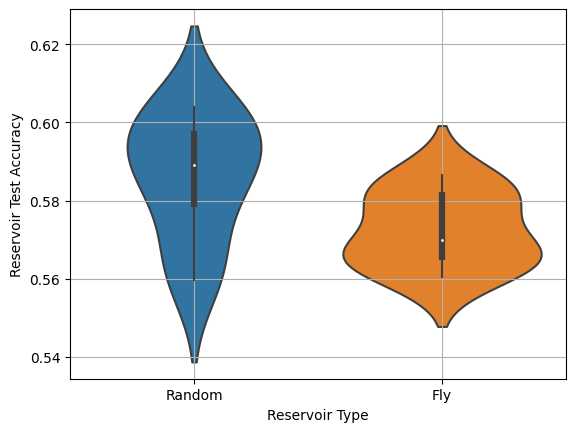

In [389]:
import seaborn as sns
sns.violinplot(x=a['Reservoir Type'], y=a["Reservoir Test Accuracy"])
# plt.ylim([0.5,0.7])
plt.grid()

In [359]:
from scipy import stats
stats.ttest_ind(ptr, ptf)

Ttest_indResult(statistic=2.067839797839108, pvalue=0.05765620673648369)

In [366]:
impo_100_fly1 = np.load('repeat_permutation_experiment_data_fly_importances_ranwhole.npy')
impo_100_fly2 = np.load('permutation_experiment_data_fly_repeat2importances_ranwhole.npy')

impo_100 = np.concatenate((impo_100_fly1,impo_100_fly2))

In [19]:
# impo_100 = np.load('permutation_experiment_data_fly_importances_ranwhole.npy') #repeats on dataset in groups of 3

node_rank_repeated = []
for idx in tqdm(range(len(impo_100))):
    l = list(impo_100[idx])
    ranking_of_nodes = [sorted(l).index(x) for x in l]
    node_rank_repeated.append(ranking_of_nodes)

impo_1002 = np.load('permutation_experiment_data_random_importances_ranwhole.npy') #repeats on dataset in groups of 3

node_rank_repeated2 = []
for idx in tqdm(range(len(impo_1002))):
    l = list(impo_1002[idx])
    ranking_of_nodes = [sorted(l).index(x) for x in l]
    node_rank_repeated2.append(ranking_of_nodes)

100%|█████████████████████████████████████████████| 32/32 [01:02<00:00,  1.95s/it]


In [114]:
def MakeNiceHist(x, n_bins, label = None):
    if n_bins == None:
        np.linspace(min(x), max(x), n_bins)
    else:
        bins = n_bins
    return plt.hist(x, bins = bins,label =label)
    
def AmazingFunction(l, thing, rule = 'eq'):
    #Gets all indicies subject to rule
    if rule == 'eq':
        return [i for i, x in enumerate(l) if x == thing]
    if rule == 'geq':
        return [i for i, x in enumerate(l) if x >= thing]
    else:
        print('add rule ')


def FlattenLists(l):
    return [item for sublist in l for item in sublist]
# MakeNiceHist(node_id_imps_aggregated, 10)



def RepwiseAggregate(list_of_ranks, rep, plot = False, reps = 3, topwhat = 100, label = None):
    node_rank_repeated2 = list_of_ranks
    node_id_imps_aggregated = []
    check_h = []
    for node_id in range(X_SIZE):
        rep_imps = node_rank_repeated2[rep:rep+reps]
        node_id_imps = [x[node_id] for x in rep_imps]
        node_id_imps_aggregated.append(np.mean(node_id_imps))
        check_h.append(len(node_id_imps))
        
#     visualise the distribution of mean ranking over a dataset
    L1, L2 = 0, X_SIZE
    if plot == True:
        if sort == 0:
            plt.scatter(np.arange(X_SIZE)[L1:L2] , (node_id_imps_aggregated)[L1:L2], s = 2, label = label)
        if sort == 1:
            plt.scatter(np.arange(X_SIZE)[L1:L2] , sorted(node_id_imps_aggregated)[L1:L2], s = 2,label = label)


#     MakeNiceHist(node_id_imps_aggregated, 100)

#     take the nodes that score an average of over 2953 - what, this is like chopping a line over the above graph
    idxs_over_what = AmazingFunction(node_id_imps_aggregated, X_SIZE - topwhat, rule = 'geq')
    
    return node_id_imps_aggregated, check_h, idxs_over_what

def GetTotalAgg(aggregate_over_reps):
    total_imp_aggregated = []
    stds = []
    check_h = []
    for node_id in range(X_SIZE):
        node_id_imps = [x[node_id] for x in aggregate_over_reps]
        total_imp_aggregated.append(np.mean(node_id_imps))
        stds.append(np.std(node_id_imps))
    
        check_h.append(len(node_id_imps))
    return total_imp_aggregated, stds

# agg, check, spec =  RepwiseAggregate(node_rank_repeated, 0 ,plot = 1)

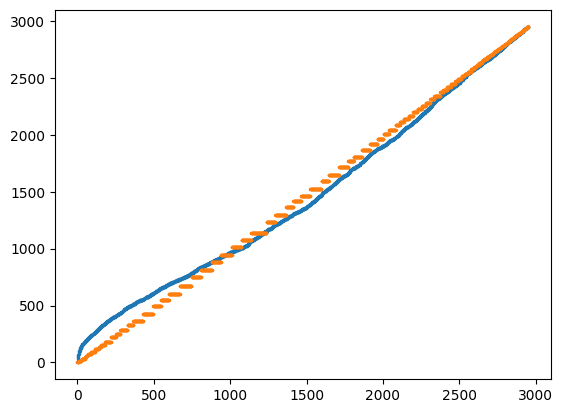

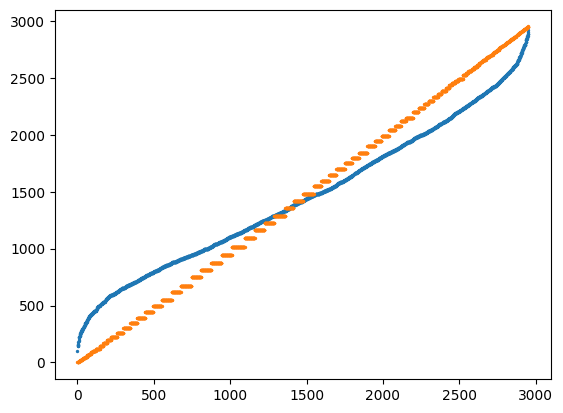

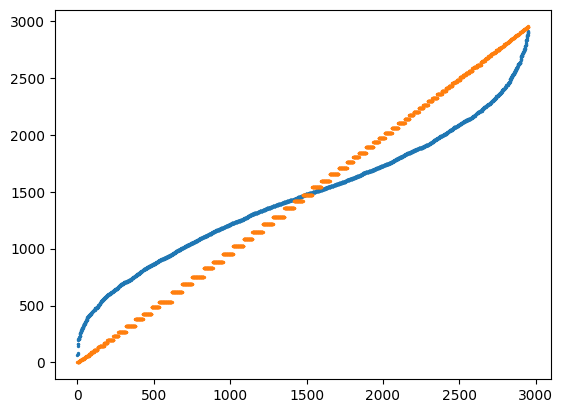

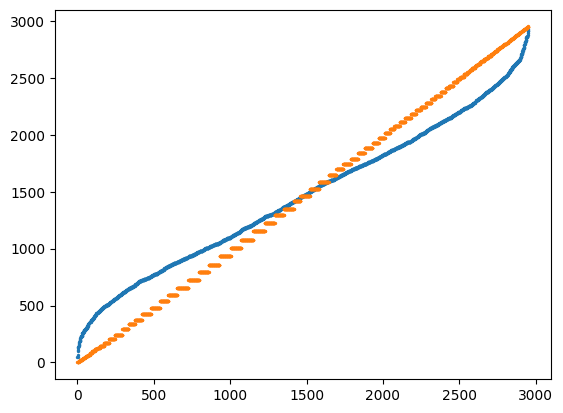

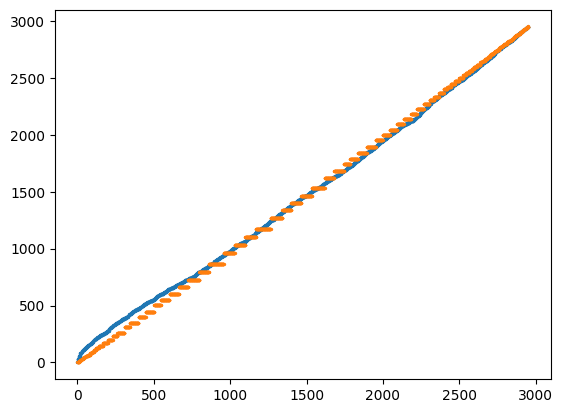

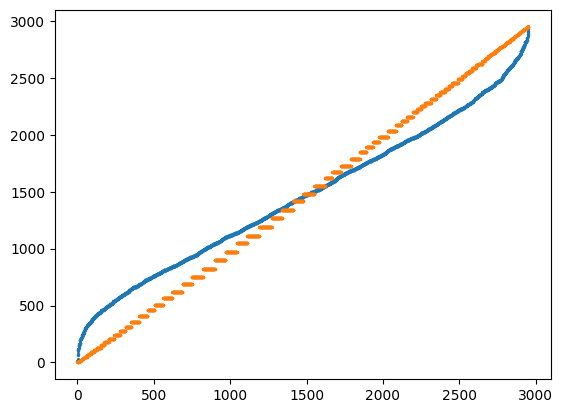

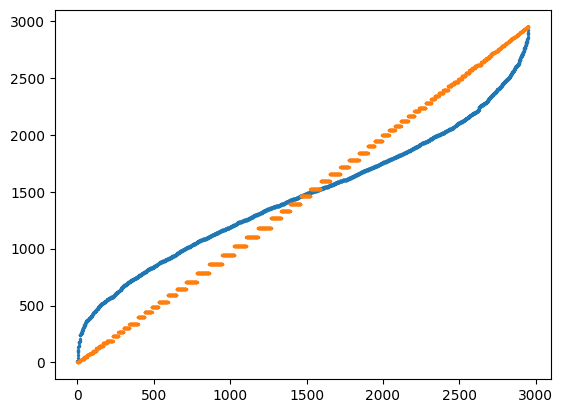

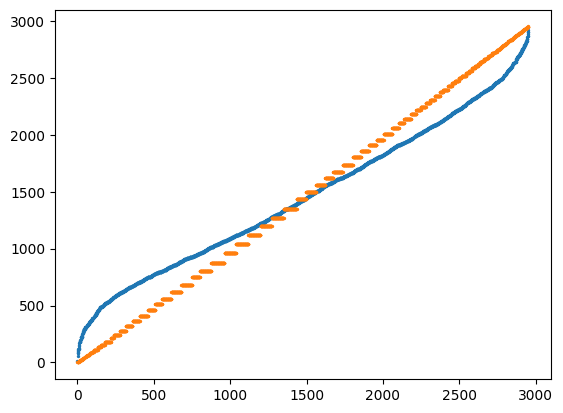

In [145]:
fly_aggregate_over_reps, fly_check_h_over_reps, fly_special_nodes = [], [], []
random_aggregate_over_reps, random_check_h_over_reps, random_special_nodes = [], [], []
plot = 1
top = 100
for rep in range(8):
    fly_agg, fly_check, fly_spec =  RepwiseAggregate(node_rank_repeated, rep ,plot = plot, reps = 4, topwhat = top)
    random_agg, random_check, random_spec =  RepwiseAggregate(node_rank_repeated2, rep ,plot = plot, reps = 1, topwhat = top)
    plt.show()
    fly_aggregate_over_reps.append(fly_agg)
    fly_special_nodes.append(fly_spec)
    random_aggregate_over_reps.append(random_agg)
    random_special_nodes.append(random_spec)

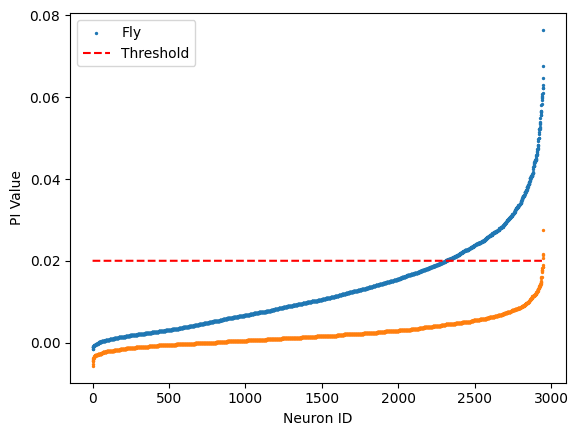

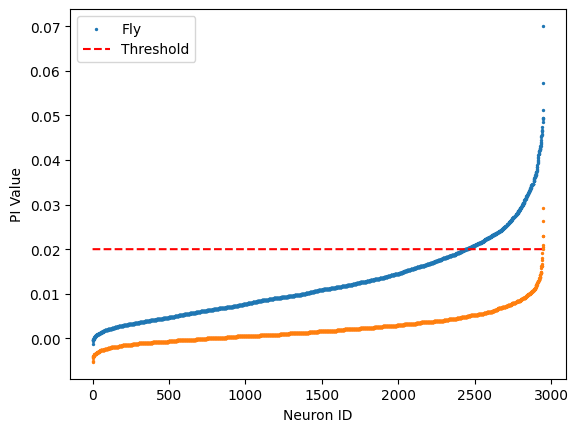

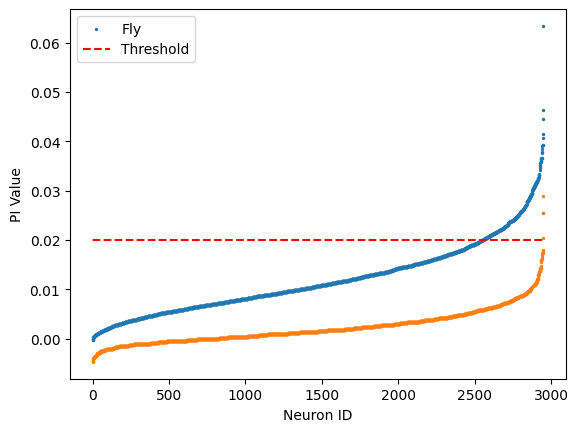

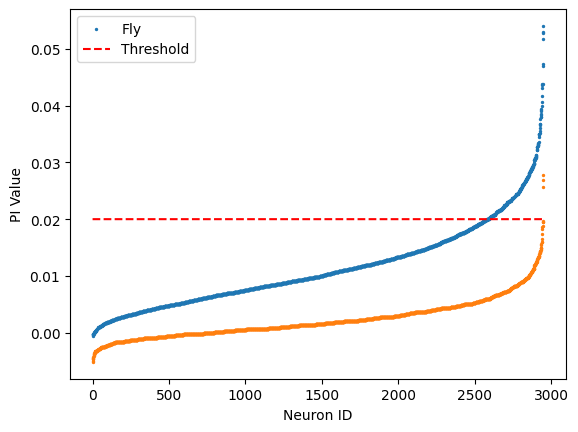

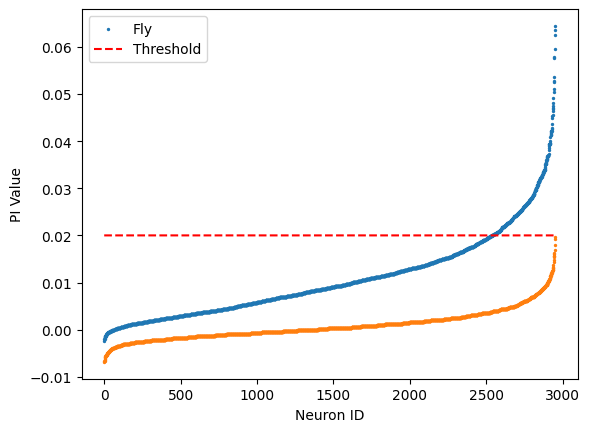

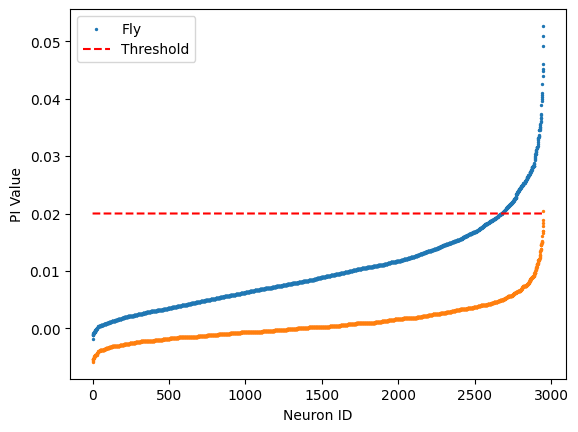

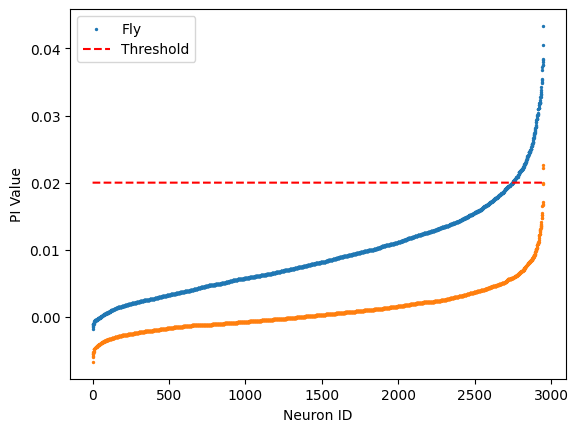

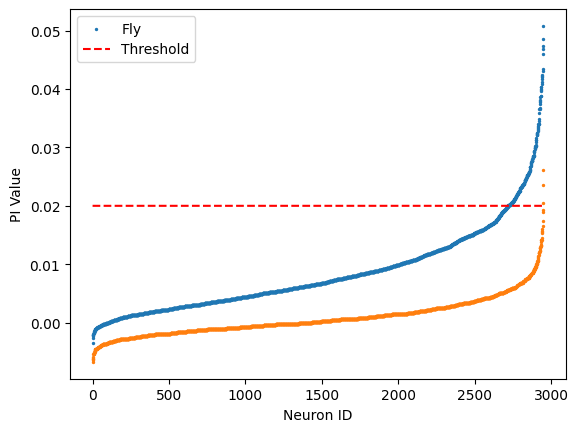

In [390]:
fly_aggregate_over_reps, fly_check_h_over_reps, fly_special_nodes = [], [], []
random_aggregate_over_reps, random_check_h_over_reps, random_special_nodes = [], [], []
plot = 1
top = X_SIZE - 0.02
thresh = 0.02
sort = 1
for rep in range(8):
    fly_agg, fly_check, fly_spec =  RepwiseAggregate(impo_100, rep ,label = 'Fly',plot = plot, reps = 4, topwhat = top)
    random_agg, random_check, random_spec =  RepwiseAggregate(impo_1002, rep ,plot = plot, reps = 1, topwhat = top)
    plt.plot(np.arange(X_SIZE), thresh*np.ones(X_SIZE), linestyle  = '--', c = 'r', label = 'Threshold')
    plt.xlabel('Neuron ID')
    plt.ylabel('PI Value')
    plt.legend()
    plt.show()
    fly_aggregate_over_reps.append(fly_agg)
    fly_special_nodes.append(fly_spec)
    random_aggregate_over_reps.append(random_agg)
    random_special_nodes.append(random_spec)

680
25


(305, 13)

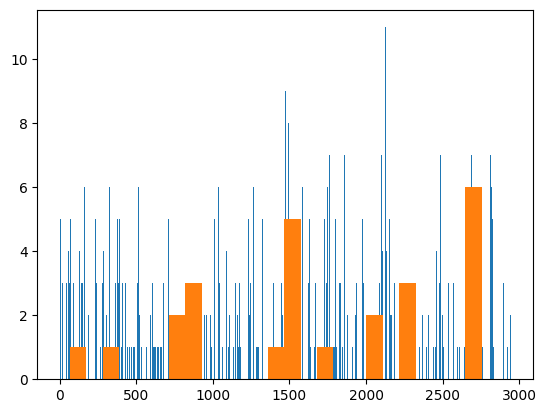

In [49]:
x = FlattenLists(fly_special_nodes)
MakeNiceHist(x, len(x))
print(len(x))
x2 = FlattenLists(random_special_nodes)
MakeNiceHist(x2, len(x2) )
print(len(x2))

len(set(x)), len(set(x2))

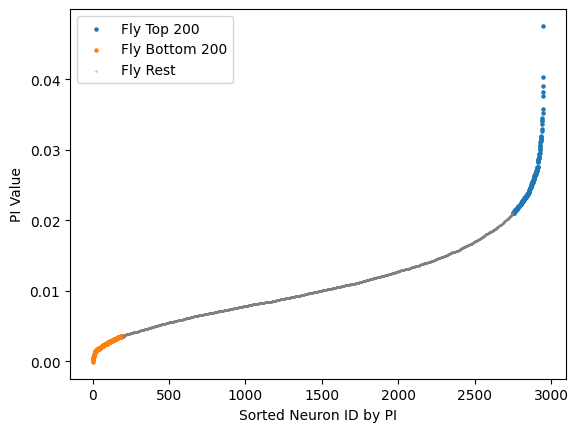

In [404]:
x, x_std = GetTotalAgg(fly_aggregate_over_reps)
top_N = 200
L1, L2 = X_SIZE - top_N, X_SIZE
scatterxs = np.arange(X_SIZE)[L1:L2]
x = sorted(x)
plt.scatter(np.arange(X_SIZE)[L1:L2] , x[L1:L2], s = 5,label = 'Fly Top 200')

x, x_std = GetTotalAgg(fly_aggregate_over_reps)
L1, L2 = X_SIZE - X_SIZE, top_N
scatterxs = np.arange(X_SIZE)[L1:L2]
x = sorted(x)
plt.scatter(np.arange(X_SIZE)[L1:L2] , x[L1:L2], s = 5,label = 'Fly Bottom 200')

x, x_std = GetTotalAgg(fly_aggregate_over_reps)
L1, L2 = top_N, X_SIZE - top_N
scatterxs = np.arange(X_SIZE)[L1:L2]
x = sorted(x)
plt.scatter(np.arange(X_SIZE)[L1:L2] , x[L1:L2], s = 0.1,label = 'Fly Rest', c = 'grey')
# plt.scatter(scatterxs , x, s = 2, label = 'fly')

# x2, x2_std= GetTotalAgg(random_aggregate_over_reps)

# x2 = sorted(x2)
# plt.scatter(np.arange(X_SIZE)[L1:L2] , x2[L1:L2], s = 2,label = 'Random')
# plt.scatter(scatterxs , x2, s = 2, label = 'random')
# plt.ylim([-10, X_SIZE])
# plt.ylabel('Average Rank (rank 1 is bad)')
# plt.xlabel('Node number post-sorted function, we can recober true node ID')
# plt.legend()
# plt.show()

# plt.plot(np.arange(X_SIZE), thresh*np.ones(X_SIZE), linestyle  = '--', c = 'r', label = 'Threshold')
plt.xlabel('Sorted Neuron ID by PI')
plt.ylabel('PI Value')
plt.legend()
plt.show()



[0.01059821428571428,
 0.03371874999999999,
 0.013718750000000002,
 0.011071428571428552,
 0.00548660714285714,
 0.006977678571428558,
 0.006415178571428575,
 0.009553571428571422,
 0.014071428571428578,
 0.018379464285714277,
 0.009343750000000001,
 0.012589285714285702,
 0.008968749999999984,
 0.00828125,
 0.006767857142857148,
 0.02066071428571428,
 0.03289285714285714,
 0.019964285714285723,
 0.005723214285714279,
 0.0061964285714285715,
 0.017084821428571425,
 0.009258928571428585,
 0.008316964285714289,
 0.009308035714285706,
 0.006897321428571433,
 0.024084821428571428,
 0.014616071428571416,
 0.012468750000000004,
 0.009508928571428581,
 0.008937500000000004,
 0.007964285714285715,
 0.007062499999999996,
 0.010718749999999992,
 0.009482142857142866,
 0.013191964285714269,
 0.005696428571428564,
 0.0017142857142857203,
 0.007258928571428583,
 0.0064330357142857245,
 0.008964285714285723,
 0.014433035714285725,
 0.004165178571428573,
 0.003955357142857146,
 0.009781249999999988,


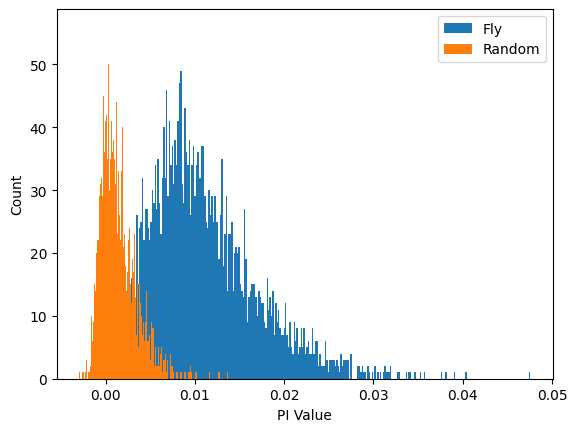

In [371]:
MakeNiceHist(x[L1:L2] , 300, label = 'Fly')
MakeNiceHist(x2[L1:L2] , 300, label = 'Random')
# plt.plot(x_gam, y_gam)
plt.ylabel('Count')
plt.xlabel('PI Value')
plt.legend()
plt.show()

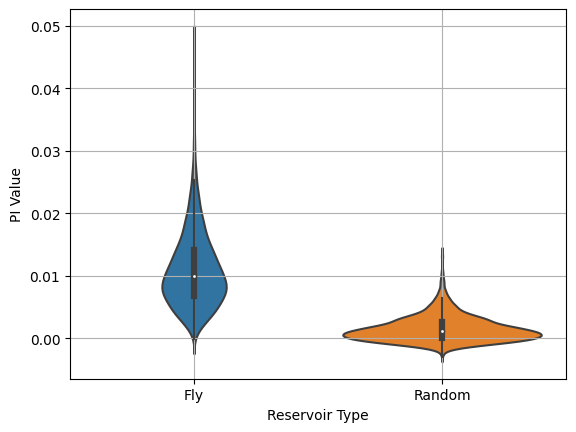

In [414]:
PIS = []
res_type = []
for i in range(len(x)):
    PIS.append(x[i])
    res_type.append('Fly')
    PIS.append(x2[i])
    res_type.append('Random')
a = pd.DataFrame()

a['Reservoir Type'], a['PI Value'] = res_type, PIS

sns.violinplot(x=a['Reservoir Type'], y=a["PI Value"])
plt.grid()


In [417]:
np.std(x)/ np.std(x2)

2.844535113283561

In [373]:
def getTopN(x, N):
    assert N != 0
    node_IDS = np.arange(X_SIZE)
    zipped = list(zip(node_IDS,x))
    zipped.sort(key=lambda x: x[1])
    return list(reversed(zipped[-N:]))

In [374]:
oi = [ o[1] for o in getTopN(x,100)]
oi2 = [ o[1] for o in list(reversed(getTopN(x, X_SIZE)))[:100]]

<AxesSubplot: xlabel='Importance', ylabel='PI Value'>

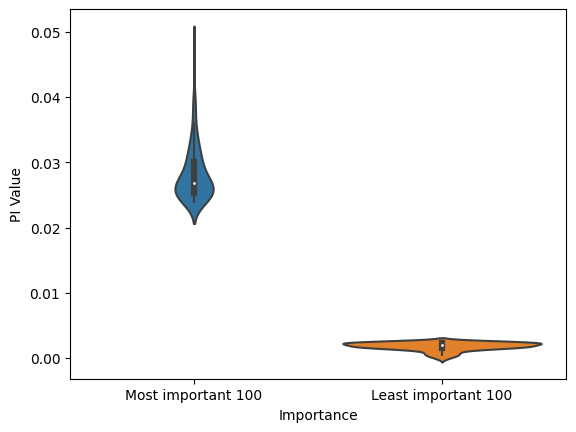

In [377]:
ois = []
res_type = []
for i in range(len(oi)):
    ois.append(oi[i])
    res_type.append('Most important 100')
    ois.append(oi2[i])
    res_type.append('Least important 100')
a = pd.DataFrame()

a['Importance'], a['PI Value'] = res_type, ois

sns.violinplot(x=a['Importance'], y=a["PI Value"])




In [378]:
best_fly_all = [ o[0] for o in getTopN(x,200)]
worst_fly_all = [ o[0] for o in list(reversed(getTopN(x, X_SIZE)))[:200]]


best_ran = [o[0] for o in getTopN(x2,100)]

In [361]:
# worst_fly_all

In [288]:
w_x_experiment = w_x_random

In [246]:
randos = (random.sample(sample_nodes,100))

In [229]:
sample_nodes = getSampleNodes(X_SIZE)

In [290]:
w_u_ranwhole = 0.5*create_weights(shape=(X_SIZE, U_SIZE), low=-1.0, high=1.0) # 500 x 29
state_xs2, state_ys2 = get_Dset(TEACH_DIGITS,N_TEACH_IMG_PAIRS, sample_nodes, remove_node_idxs,
                            w_u_ranwhole, w_x_experiment , ones = 1)
test_xs2, test_ys2 = get_Dset(TEST_DIGITS,N_TEST_IMG_PAIRS, sample_nodes, remove_node_idxs,
                         w_u_ranwhole, w_x_experiment, ones = 1)

In [198]:
w_u_ranwhole = 0.5*create_weights(shape=(X_SIZE, U_SIZE), low=-1.0, high=1.0) # 500 x 29
state_xs, state_ys = get_Dset(TEACH_DIGITS,N_TEACH_IMG_PAIRS, sample_nodes, remove_node_idxs,
                            w_u_ranwhole, w_x_experiment , ones = 1)
test_xs, test_ys = get_Dset(TEST_DIGITS,N_TEST_IMG_PAIRS, sample_nodes, remove_node_idxs,
                         w_u_ranwhole, w_x_experiment, ones = 1)

In [363]:
best_fly_all[:5], worst_fly_all[:5]

([1262, 2360, 1978, 1761, 1491], [2659, 539, 373, 2547, 2330])

In [385]:
best_ps = []
worst_ps = []

for orange in tqdm(range(1,200)):
    best_fly = best_fly_all[:orange]
    trainX = [ah[best_fly] for ah in state_xs2]
    testX = [ah[best_fly] for ah in test_xs2]
    forest = LinearSVC(dual = False)
    forest.fit(trainX, state_ys)
    pred_state_ys = forest.predict(trainX)
    pred_test_ys = forest.predict(testX)
    tr_acc = accuracy_score(pred_state_ys, state_ys)
    te_acc = accuracy_score(pred_test_ys, test_ys)
    best_ps.append([tr_acc,te_acc])
    
    worst_fly = worst_fly_all[:orange]
    trainX = [ah[worst_fly] for ah in state_xs2]
    testX = [ah[worst_fly] for ah in test_xs2]
    forest = LinearSVC(dual = False)
    forest.fit(trainX, state_ys)
    pred_state_ys = forest.predict(trainX)
    pred_test_ys = forest.predict(testX)
    tr_acc = accuracy_score(pred_state_ys, state_ys)
    te_acc = accuracy_score(pred_test_ys, test_ys)
    worst_ps.append([tr_acc,te_acc])

100%|███████████████████████████████████████████| 199/199 [05:36<00:00,  1.69s/it]


In [423]:
len(np.diff(AmazingFunction((np.array(bests) - np.array(worsts)), 0, rule = 'geq' )))

185

Text(0, 0.5, 'Test Accuracy')

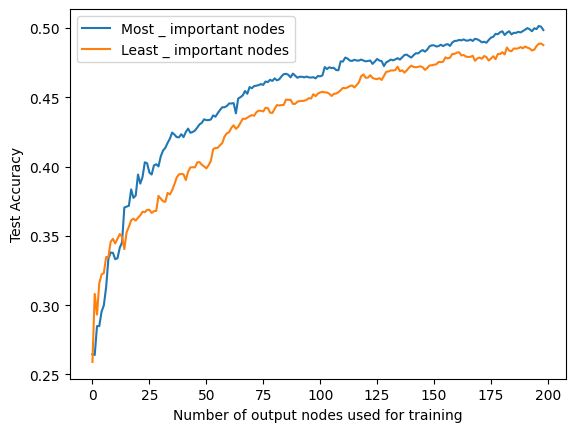

In [386]:
bests = [o[1] for o in best_ps]
worsts = [o[1] for o in worst_ps]
plt.plot(np.arange(200-1), bests, label = 'Most _ important nodes')
plt.plot(np.arange(200-1), worsts, label = 'Least _ important nodes')
plt.legend()
plt.xlabel('Number of output nodes used for training')
plt.ylabel('Test Accuracy')

In [429]:
min(worsts), min(bests)

(0.259, 0.264)

Text(0, 0.5, 'Count')

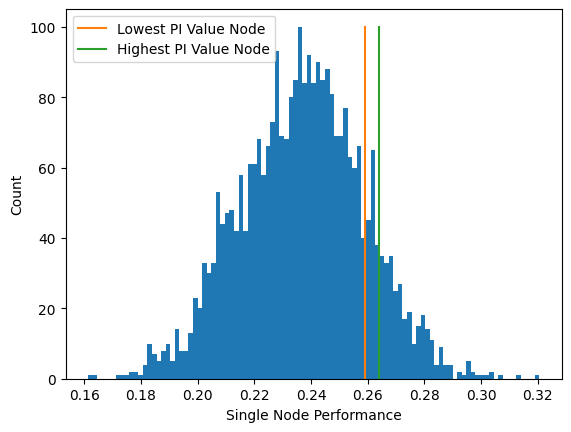

In [434]:
a = plt.hist(tes, bins = np.linspace(min(tes), max(tes), 100))
K = min(worsts)
plt.plot(K*np.ones(10), np.linspace(0,100,10), label = 'Lowest PI Value Node')
K = min(bests)
plt.plot(K*np.ones(10), np.linspace(0,100,10), label = 'Highest PI Value Node')
plt.legend()
plt.xlabel('Single Node Performance')
plt.ylabel('Count')

In [411]:
# np.save('ONENEURONESEARCH.npy', tes)

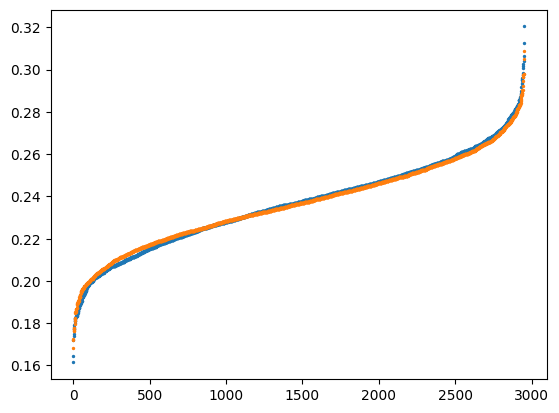

In [409]:
trs2 = [o[0] for o in best_ps2]
tes2 = [o[1] for o in best_ps2]

# plt.scatter(np.arange(X_SIZE-1), sorted(tes), s = 2)
# plt.scatter(np.arange(X_SIZE-1), sorted(tes2), s = 2)
# plt.scatter(np.arange(X_SIZE-1), tes, s = 2)
# plt.plot(trs2)
# plt.plot(tes2)

In [296]:
print(np.mean(tes), np.mean(tes2))
print(np.max(tes), np.max(tes2))
print(np.min(tes), np.min(tes2))




0.23682069032289293 0.23672590405189525
0.32042857142857145 0.30885714285714283
0.16142857142857142 0.16814285714285715


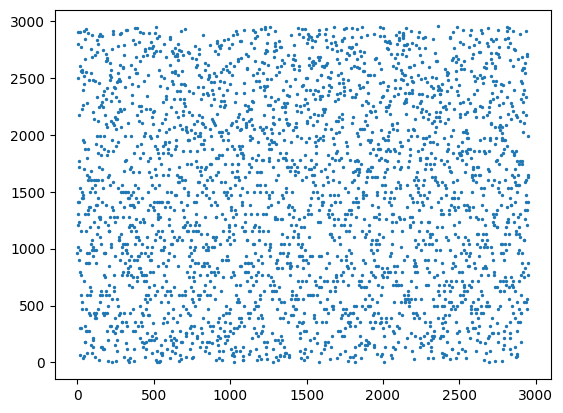

In [140]:
sort = 0
a,b,c  = RepwiseAggregate(node_rank_repeated, rep ,plot = 1, reps = 1, topwhat = top)
plt.show()


In [299]:
print('FLy vs Random')
print('Max' ,np.max(x), np.max(x2))
print('Min' ,np.min(x), np.min(x2))
print('Mean' ,np.mean(x), np.mean(x2))
print('Stds' ,np.std(x), np.std(x2))

FLy vs Random
Max 0.03525000000000002 0.013678571428571415
Min -0.00396875 -0.0029464285714286
Mean 0.0048402535811072405 0.00153599859659309
Stds 0.004742713428626394 0.0021081681018808264


In [384]:
np.save('arepeated_std_PI_fly.npy', x_std)

In [228]:
len(AmazingFunction(x, 0.01, rule = 'geq'))

364

In [ ]:
x = GetTotalAgg(fly_aggregate_over_reps)
L1, L2 = X_SIZE - 100, X_SIZE
scatterxs = np.arange(X_SIZE)[L1:L2]
x = sorted(x)[L1:L2]
# plt.scatter(np.arange(X_SIZE)[L1:L2] , x[L1:L2], s = 2)
plt.scatter(scatterxs , x, s = 2, label = 'fly')

x2= GetTotalAgg(random_aggregate_over_reps)
x2 = sorted(x2)[L1:L2]
# plt.scatter(np.arange(X_SIZE)[L1:L2] , x2[L1:L2], s = 2)
plt.scatter(scatterxs , x2, s = 2, label = 'random')
plt.ylim([min([min(x), min(x2)]), max([max(x), max(x2)])])
plt.ylabel('Average Rank (rank 1 is bad)')
plt.xlabel('Node number post-sorted function, we can recober true node ID')
plt.legend()
plt.show()

MakeNiceHist(x, 100)
MakeNiceHist(x2, 100)

plt.show()



In [ ]:
fly_agg, fly_check, fly_spec =  RepwiseAggregate(x, rep ,plot = plot, reps = 4, topwhat = top)



In [ ]:
print('FLy vs Random')
print('Max' ,np.max(x), np.max(x2))
print('Min' ,np.min(x), np.min(x2))
print('Mean' ,np.mean(x), np.mean(x2))
print('Stds' ,np.std(x), np.std(x2))

In [ ]:
print('FLy vs Random')
print('Max' ,np.max(x), np.max(x2))
print('Min' ,np.min(x), np.min(x2))
print('Mean' ,np.mean(x), np.mean(x2))
print('Stds' ,np.std(x), np.std(x2))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

ax[0].scatter(ids, imps, s = 2)
ax[1].scatter(ids2, imps2, s = 2)

ax[0].set_ylim([0,1.2*max(imps)])
ax[1].set_ylim([0,1.2*max(imps2)])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

ax[0].scatter(ids, imps, s = 2)
ax[1].scatter(ids2, imps2, s = 2)

ax[0].set_ylim([0,1.2*max(imps)])
ax[1].set_ylim([0,1.2*max(imps2)])

In [ ]:
np.mean([x[1] for x in performance]), np.mean([x[1] for x in performance2])

In [ ]:
r7a = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
                  , w_u = w_u_ranhalf, w_x=w_x_flynorm)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# r1 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_ranhalf, w_x=w_x_random)

# r2 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_ranhalf, w_x=w_x_flynorm)

# r3 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_ranwhole, w_x=w_x_random)

# r4 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_ranwhole, w_x=w_x_flynorm)

# r5 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_oneshalf, w_x=w_x_random)
# r6 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_oneshalf, w_x=w_x_flynorm)

# r7 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_oneswhole, w_x=w_x_random)
# r8 = run_full_res(model = RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
#                   , w_u = w_u_oneswhole, w_x=w_x_flynorm)

In [ ]:
print(r1[-3:], r2[-3:])
print(r3[-3:], r4[-3:])
print(r5[-3:], r6[-3:])
print(r7[-3:], r8[-3:])

In [ ]:
#  SAVING DATA
# n_inputs = fly_matnp.shape[0]
# n_outputs = fly_matnp.shape[0]
# # input_node_idxs = getSampleNodes(n_inputs)
# # sample_nodes = getSampleNodes(n_outputs)

# x,y = get_Dset(TEACH_DIGITS,N_TEACH_IMG_PAIRS, sample_nodes, remove_node_idxs)
# np.save('data/ones_fly'+str(n_inputs)+'_trainX.npy', x)
# np.save('data/ones_fly'+str(n_inputs)+'_trainY.npy', y)
# print(x.shape, y.shape)
# x,y = get_Dset(TEST_DIGITS,N_TEST_IMG_PAIRS, sample_nodes, remove_node_idxs)
# np.save('data/ones_fly'+str(n_inputs)+'_testX.npy', x)
# np.save('data/ones_fly'+str(n_inputs)+'_testY.npy', y)
# print(x.shape, y.shape)